In [4]:
import os
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
from networkx.drawing.layout import kamada_kawai_layout
from itertools import combinations

In [42]:

def analyze_graph(graph):
    """Compute basic graph statistics."""
    num_nodes = graph.number_of_nodes()
    num_edges = graph.number_of_edges()
    avg_degree = sum(dict(graph.degree()).values()) / num_nodes if num_nodes > 0 else 0
    density = nx.density(graph)
    is_directed = graph.is_directed()
    diameter = nx.diameter(graph) if nx.is_connected(graph) else -1  # -1 for disconnected graphs
    avg_shortest_path = nx.average_shortest_path_length(graph) if nx.is_connected(graph) else -1
    num_components = nx.number_connected_components(graph)
    assortativity = nx.degree_assortativity_coefficient(graph)

    return {
        "Nodes": num_nodes,
        "Edges": num_edges,
        "Avg Degree": avg_degree,
        "Density": density,
        "Directed": is_directed,
        "Diameter": diameter,
        "Avg Shortest Path": avg_shortest_path,
        "Num Components": num_components,
        "Assortativity": assortativity
    }

def compute_force_directed_layout(graph):
    """Computes  positions using  Kamada-Kawai force-directed layout."""
    return kamada_kawai_layout(graph)

def count_edge_crossings(graph, pos):
    """number of edge crossings based on node positions."""
    crossings = 0
    edges = list(graph.edges())

    for (u1, v1), (u2, v2) in combinations(edges, 2):
        # Extract positions
        x1, y1 = pos[u1]
        x2, y2 = pos[v1]
        x3, y3 = pos[u2]
        x4, y4 = pos[v2]

        # Check if edges (u1, v1) and (u2, v2) cross
        def ccw(a, b, c):
            return (c[1] - a[1]) * (b[0] - a[0]) > (b[1] - a[1]) * (c[0] - a[0])

        if (ccw((x1, y1), (x3, y3), (x4, y4)) != ccw((x2, y2), (x3, y3), (x4, y4))) and \
           (ccw((x1, y1), (x2, y2), (x3, y3)) != ccw((x1, y1), (x2, y2), (x4, y4))):
            crossings += 1

    return crossings

def process_graphml_folder(folder_path, output_folder):
    """Processes all .graphml files, updates node positions, adds attributes, and saves them."""
    graph_stats = []

    for file in os.listdir(folder_path):
        if file.endswith(".graphml"):
            file_path = os.path.join(folder_path, file)
            try:
                graph = nx.read_graphml(file_path)
                stats = analyze_graph(graph)
                pos = compute_force_directed_layout(graph)  # Compute node positions

                # Compute centrality metrics
                clustering_coeffs = nx.clustering(graph)
                betweenness_centrality = nx.betweenness_centrality(graph)
                
                # **Fix for eigenvector centrality**
                try:
                    eigenvector_centrality = nx.eigenvector_centrality(graph, max_iter=1000)
                except nx.PowerIterationFailedConvergence:
                    print(f"⚠️ Warning: Eigenvector centrality failed for {file}. Skipping this feature.")
                    eigenvector_centrality = {node: None for node in graph.nodes()}  # Store None or default value

                pagerank_scores = nx.pagerank(graph)

                # Compute edge betweenness centrality
                edge_betweenness = nx.edge_betweenness_centrality(graph)

                # Store graph-level attributes
                graph.graph["edge_crossings"] = stats["Edges"]
                graph.graph["diameter"] = stats["Diameter"]
                graph.graph["avg_shortest_path"] = stats["Avg Shortest Path"]
                graph.graph["num_components"] = stats["Num Components"]
                graph.graph["assortativity"] = stats["Assortativity"]

                # Store node attributes
                for node, (x, y) in pos.items():
                    graph.nodes[node]['x_pos'] = float(x)
                    graph.nodes[node]['y_pos'] = float(y)
                    graph.nodes[node]['degree'] = graph.degree[node]
                    graph.nodes[node]['clustering'] = clustering_coeffs[node]
                    graph.nodes[node]['betweenness'] = betweenness_centrality[node]
                    graph.nodes[node]['eigenvector'] = eigenvector_centrality[node] if eigenvector_centrality[node] is not None else 0  # Default 0
                    graph.nodes[node]['pagerank'] = pagerank_scores[node]

                # Store edge attributes
                for edge in graph.edges():
                    graph.edges[edge]['betweenness'] = edge_betweenness[edge]

                graph_stats.append(stats)

                # Save updated graph to a new file
                output_file_path = os.path.join(output_folder, file)
                nx.write_graphml(graph, output_file_path)

            except Exception as e:
                print(f"❌ Error processing {file}: {e}")

    return pd.DataFrame(graph_stats)



# Rome Graphs 1



In [45]:
current_folder = os.getcwd() 
folder_path = os.path.join(current_folder, "rome1") 
folder_path_out = os.path.join(current_folder, "rome1_processed") 
df = process_graphml_folder(folder_path,folder_path_out)
df.tail()

,Nodes,Edges,Avg Degree,Density,Directed,Diameter,Avg Shortest Path,Num Components,Assortativity
464,18,17,1.888889,0.111111,False,11,4.666667,1,-0.582996
465,11,13,2.363636,0.236364,False,4,2.345455,1,-0.181818
466,11,12,2.181818,0.218182,False,6,2.618182,1,-0.363636
467,16,15,1.875000,0.125000,False,9,3.908333,1,-0.469595
468,13,13,2.000000,0.166667,False,8,3.628205,1,0.057971


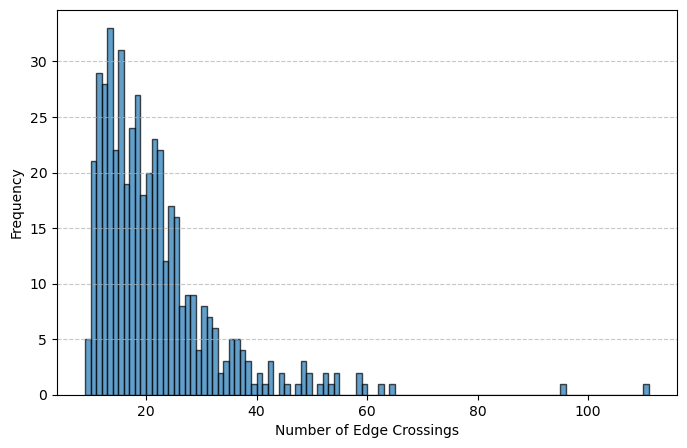

In [52]:
plt.figure(figsize=(8, 5))
plt.hist(df["Edges"], bins=range(min(df["Edges"]), max(df["Edges"]) + 2), edgecolor='black', alpha=0.7)
plt.xlabel("Number of Edge Crossings")
plt.ylabel("Frequency")
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.show()

In [48]:
print(df.columns)  # Check existing column names


Index(['Nodes', 'Edges', 'Avg Degree', 'Density', 'Directed', 'Diameter',
       'Avg Shortest Path', 'Num Components', 'Assortativity'],
      dtype='object')
